<a href="https://colab.research.google.com/github/AshishRaj04/her/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd

In [4]:
# Hyperparameters
vocab_size = 512
emb_dim = 386
n_heads = 8
dk = emb_dim // n_heads
context_length = 128
Nx = 6
dropout = 0.2


class PositionEncoding(tf.keras.layers.Layer):
    def __init__(self, context_length, d_model):
        super().__init__()
        self.context_length = context_length
        self.d_model = d_model

        position = tf.range(context_length, dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(
            tf.range(0, d_model, 2, dtype=tf.float32)
            * (-tf.math.log(10000.0) / d_model)
        )

        pe = np.zeros((context_length, d_model), dtype=np.float32)
        pe[:, 0::2] = np.sin(position.numpy() * div_term.numpy())
        pe[:, 1::2] = np.cos(position.numpy() * div_term.numpy())
        self.pe = tf.constant(pe)[tf.newaxis, ...]

    def call(self, inputs):
        return self.pe[:, : tf.shape(inputs)[1], :]


class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, dk):
        super().__init__()
        self.initializer = tf.keras.initializers.GlorotUniform()
        self.WK = tf.Variable(self.initializer(shape=(emb_dim, dk)), trainable=True)
        self.WQ = tf.Variable(self.initializer(shape=(emb_dim, dk)), trainable=True)
        self.WV = tf.Variable(self.initializer(shape=(emb_dim, dk)), trainable=True)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.mask = 1 - tf.linalg.band_part(
            tf.ones((context_length, context_length)), -1, 0
        )
        self.mask = self.mask * -1e9

    def call(self, x, training=False):
        B, T, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
        key = x @ self.WK
        query = x @ self.WQ
        value = x @ self.WV

        wei = query @ tf.transpose(key, [0, 2, 1])
        wei = wei / tf.math.sqrt(tf.cast(dk, tf.float32))
        wei = wei + self.mask[:T, :T]
        wei = tf.nn.softmax(wei, axis=-1)
        wei = self.dropout(wei, training=training)
        out = wei @ value
        return out


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, n_heads, dk):
        super().__init__()
        self.initializer = tf.keras.initializers.GlorotUniform()
        self.heads = [SelfAttention(dk) for _ in range(n_heads)]
        self.WO = tf.Variable(
            self.initializer(shape=(n_heads * dk, emb_dim)), trainable=True
        )
        self.dropout = tf.keras.layers.Dropout(dropout)

    def call(self, x):
        out = tf.concat([h(x) for h in self.heads], axis=-1)
        out = out @ self.WO
        return out


class FeedForward(tf.keras.layers.Layer):
    def __init__(self, emb_dim):
        super().__init__()
        self.network = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(4 * emb_dim),
                tf.keras.layers.ReLU(),
                tf.keras.layers.Dense(emb_dim),
                tf.keras.layers.Dropout(dropout),
            ]
        )

    def call(self, x):
        return self.network(x)


class Block(tf.keras.layers.Layer):
    def __init__(self, emb_dim, dk, n_heads):
        super().__init__()
        self.attention = MultiHeadAttention(n_heads, dk)
        self.ffwd = FeedForward(emb_dim)
        self.ln1 = tf.keras.layers.LayerNormalization()
        self.ln2 = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = x + self.attention(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class DecoderTransformer(tf.keras.Model):
    def __init__(self , vocab_size , emb_dim , n_heads ,  Nx):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, emb_dim)
        self.pos_emb = PositionEncoding(context_length, emb_dim)
        self.blocks = tf.keras.Sequential(
            [Block(emb_dim, emb_dim // n_heads, n_heads) for _ in range(Nx)]
        )
        self.ln = tf.keras.layers.LayerNormalization()
        self.lm_head = tf.keras.layers.Dense(vocab_size)
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    def call(self, xb):
        te = self.token_emb(xb)
        pe = self.pos_emb(xb)
        emb = te + pe
        x = self.blocks(emb)
        x = self.ln(x)
        logits = self.lm_head(x)  # (B , T , vocab_size)
        return logits

    def compute_loss(self, xb, yb):
        logits = self(xb)
        logits_flat = tf.reshape(logits, (-1, logits.shape[2]))  # (B * T , vocab_size)
        target_flat = tf.reshape(yb, (-1))  # (B * T)
        loss = self.loss_fn(target_flat, logits_flat)
        loss = tf.reduce_mean(loss)
        return loss

In [5]:
def get_stats(ids):
    counts = {}
    for pair in zip(ids, ids[1:]):
        counts[pair] = counts.get(pair, 0) + 1
    return counts

def merge_stats(tokens, pair, idx):
    new_tokens = []
    i = 0
    while i < len(tokens):
        if i < len(tokens) - 1 and tokens[i] == pair[0] and tokens[i+1] == pair[1]:
            new_tokens.append(idx)
            i += 2
        else:
            new_tokens.append(tokens[i])
            i += 1
    return new_tokens

class Tokenizer:
    def __init__(self):
        self.merges = {}  # (int, int) -> int
        self.vocab = {}   # int -> bytes

    def train(self, text, vocab_size, verbose=False):
        assert vocab_size >= 256
        num_merge = vocab_size - 256

        text_bytes = text.encode("utf-8")
        ids = list(text_bytes)

        merges = {}
        vocab = {idx: bytes([idx]) for idx in range(256)}

        for i in range(num_merge):
            stats = get_stats(ids)
            if not stats:
                break
            pair = max(stats, key=stats.get)
            idx = 256 + i
            ids = merge_stats(ids, pair, idx)
            merges[pair] = idx
            vocab[idx] = vocab[pair[0]] + vocab[pair[1]]
            if verbose:
                print(f"merge {i+1}/{num_merge}: {pair} -> {idx} ({vocab[idx]}) had {stats[pair]} occurrences")

        self.merges = merges
        self.vocab = vocab

    def encode(self, text):
        tokens = list(text.encode("utf-8"))
        while len(tokens) >= 2:
            stats = get_stats(tokens)
            pair = min(stats, key=lambda p: self.merges.get(p, float("inf")))
            if pair not in self.merges:
                break
            idx = self.merges[pair]
            tokens = merge_stats(tokens, pair, idx)
        return tokens

    def decode(self, ids):
        tokens = b"".join(self.vocab[idx] for idx in ids)
        text = tokens.decode("utf-8", errors="replace")
        return text


In [6]:
tokenizer = Tokenizer()

In [7]:
model = DecoderTransformer(vocab_size, emb_dim, n_heads, Nx)

In [8]:
sonnet_path = "/content/drive/MyDrive/Transformer/WhatsApp Chat with Shreya.txt"

In [9]:
with open(sonnet_path , "r", encoding='utf-8') as f:
    text = f.read()

In [10]:
tokenizer.train(text, vocab_size=512 , verbose=False)

In [15]:
encoded = tokenizer.encode(text[1000:])
# print("Encoded:", encoded)

In [16]:
print("encoded token length:", len(encoded))
print("text characters length:", len(text))
print(f"compression ratio: {len(text) / len(encoded):.2f}X")

encoded token length: 186303
text characters length: 479304
compression ratio: 2.57X


In [ ]:
# decoded = tokenizer.decode(encoded)
# print("Decoded:", decoded)

### Create sequences using `tf.data.Dataset`

In [17]:
context_length = 128
buffer_size = 10000
batch_size = 64

In [18]:
token_ds = tf.data.Dataset.from_tensor_slices(encoded)

In [19]:
# Create sequences of seq_length+1 (last one is the target)
sequences = token_ds.window(size=context_length+1, shift=1, drop_remainder=True)
sequences = sequences.flat_map(lambda window: window.batch(context_length + 1))

In [20]:
def split_input_target(seq):
    input_text = seq[:-1]
    target_text = seq[1:]
    return input_text, target_text

In [21]:
dataset = sequences.map(split_input_target)

In [22]:
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [23]:
for element in dataset.as_numpy_iterator():
  x , y = element
  print(x.shape)
  print(y.shape)
  break

(64, 128)
(64, 128)


In [24]:
count = 0
for _ in dataset.as_numpy_iterator():
    count += 1
print(f"The dataset has {count} elements.")

The dataset has 2908 elements.


In [25]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 3e-4)

In [26]:
losses = []
epoch = 0
for element in dataset.as_numpy_iterator():
    epoch += 1
    xb, yb = element
    with tf.GradientTape() as tape:
        loss = model.compute_loss(xb,yb)
    grad = tape.gradient(loss , model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    losses.append(loss)
    if epoch % 10 == 0:
      print(f"epoch={epoch}, loss={loss.numpy():.4f}")
    # if epoch == 100:
    #   break

epoch=10, loss=5.2828
epoch=20, loss=4.9456
epoch=30, loss=5.0660
epoch=40, loss=5.0924
epoch=50, loss=5.0898
epoch=60, loss=4.8952
epoch=70, loss=4.8615
epoch=80, loss=4.4785
epoch=90, loss=4.3519
epoch=100, loss=4.3499
epoch=110, loss=4.1766
epoch=120, loss=4.1543
epoch=130, loss=3.9452
epoch=140, loss=3.9861
epoch=150, loss=3.6402
epoch=160, loss=3.7612
epoch=170, loss=3.8369
epoch=180, loss=3.5219
epoch=190, loss=3.7316
epoch=200, loss=3.4952
epoch=210, loss=3.3876
epoch=220, loss=3.5128
epoch=230, loss=3.5084
epoch=240, loss=3.3944
epoch=250, loss=3.1251
epoch=260, loss=3.2613
epoch=270, loss=3.3582
epoch=280, loss=3.1824
epoch=290, loss=3.1465
epoch=300, loss=3.1606
epoch=310, loss=3.2430
epoch=320, loss=3.1023
epoch=330, loss=3.0482
epoch=340, loss=3.0127
epoch=350, loss=2.9306
epoch=360, loss=2.8722
epoch=370, loss=2.9110
epoch=380, loss=2.8042
epoch=390, loss=2.7409
epoch=400, loss=2.8198
epoch=410, loss=2.8030
epoch=420, loss=2.8334
epoch=430, loss=2.7945
epoch=440, loss=2.77

In [27]:
# Save full model (recommended)
model.save('shreya_transformer_full.keras')


In [29]:
# Save only the weights
model.save_weights('shreya_transformer_weights.weights.h5')


In [30]:
losses[-1]

<tf.Tensor: shape=(), dtype=float32, numpy=0.12690401077270508>

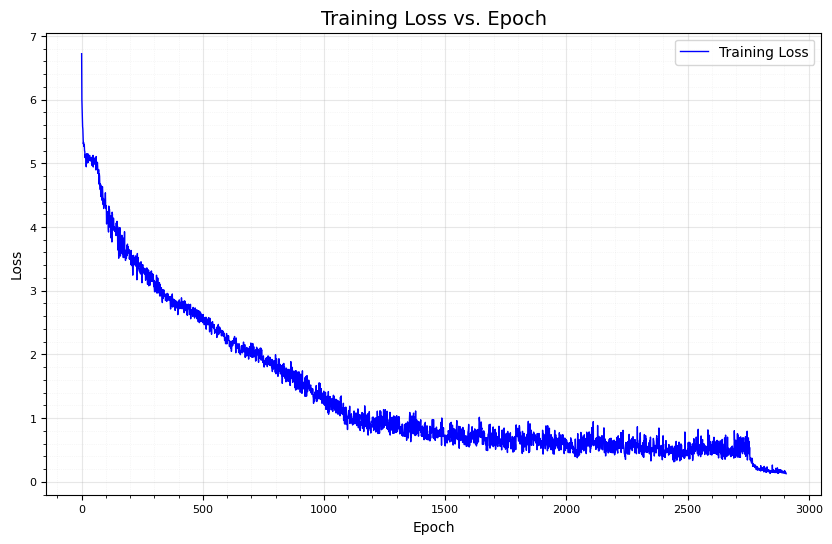

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(losses, linestyle='-',linewidth=1, color='blue', label='Training Loss')


plt.title('Training Loss vs. Epoch', fontsize=14)
plt.xlabel('Epoch', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.grid(True, alpha=0.3)

plt.legend(fontsize=10)

plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', alpha=0.2)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8  )

plt.show()

In [35]:
generated = []
context = [0] * context_length  # Start context

for _ in range(5000):  # Generate 350 tokens
    Xb = tf.constant([context], dtype=tf.int32)  # Shape (1, T)

    logits = model.call(Xb)

    # Take the logits at the last position
    last_logits = logits[:, -1, :]              # (1, vocab_size)
    probs = tf.nn.softmax(last_logits, axis=-1) # (1, vocab_size)

    ix = tf.random.categorical(tf.math.log(probs), num_samples=1)[0, 0].numpy()
    context = context[1:] + [ix]  # Slide the context window
    generated.append(ix)


In [36]:
decoded = tokenizer.decode(generated)
print("Decoded:", decoded)

Decoded: Wram u rya
2/15/25, 23:22 - Shreya: Ha�5/25, 23:23 - Shreya: 🤣🤣jyada lge hai
2/24/25, 23:23 - Raj: Obd elli
2/11/25, 00:22 - Shreya: STK-2025011-WA0013.webp (file attached)
2/11/25, 17:22 - Shreya: Kal 10 hi we sure ure
2/119/25, 23:22 - Raj: Et3/1Ku
12/20/25, 19:43 - Shreya: Uthi call krna�a i nhi rhi hai
2/20/25, 19:23 - Raj: up
1/20/25, 19:24 - Shreya: Oh
1/20/25, 19:24 - Shreya: Nth mere bitch me ho jate j ya hi nhi kpMedia 21 - Raj: I'm r rhe hua tum do <This message was edited>
2/25/25, 00:26 - Raj: Yeet and baad uth sath ma phone
2/25/25, 00:27 - Shreya: Yupped oky
2/25/25, 00:28 - Raj: Kya hua
2/25/25, 01:30 - Shreya: VID-20250223-WA0003u rule.
2/25/25, 01:35 - Shreya: Did your mile star3 - Raj: i femaotive hom rother to What hari ho last  krke hai
2/2/25, 20:04 - Raj: Wo p<Media omitted>
2/20/25, 23:44 - Shreya: Ohh
2/20/25, 23:45 - Shreya: It do
2/20/25, 23:45 - Shreya:  morning bt i wanna
2/20/25, 23:46 - Shreya: Wahi way bwadhk
2/10/25, 23:46 - Shreya: <Media omitt

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipython-input-39-3252641314.py:44: UserWarning: Glyph 0 ( ) missing from font(s) DejaVu Sans.
  plt.savefig(plot_save_path, dpi=300)
/tmp/ipython-input-39-3252641314.py:44: UserWarning: Glyph 1 () missing from font(s) DejaVu Sans.
  plt.savefig(plot_save_path, dpi=300)
/tmp/ipython-input-39-3252641314.py:44: UserWarning: Glyph 2 () missing from font(s) DejaVu Sans.
  plt.savefig(plot_save_path, dpi=300)
/tmp/ipython-input-39-3252641314.py:44: UserWarning: Glyph 3 () missing from font(s) DejaVu Sans.
  plt.savefig(plot_save_path, dpi=300)
/tmp/ipython-input-39-3252641314.py:44: UserWarning: Glyph 4 () missing from font(s) DejaVu Sans.
  plt.savefig(plot_save_path, dpi=300)
/tmp/ipython-input-39-3252641314.py:44: UserWarning: Glyph 5 () missing from font(s) DejaVu Sans.
  plt.savefig(plot_save_path

Plot saved to ./token_embeddings_tsne_plot.png


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 0 ( ) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 5 () missing from font(s) DejaVu Sans.
  fi

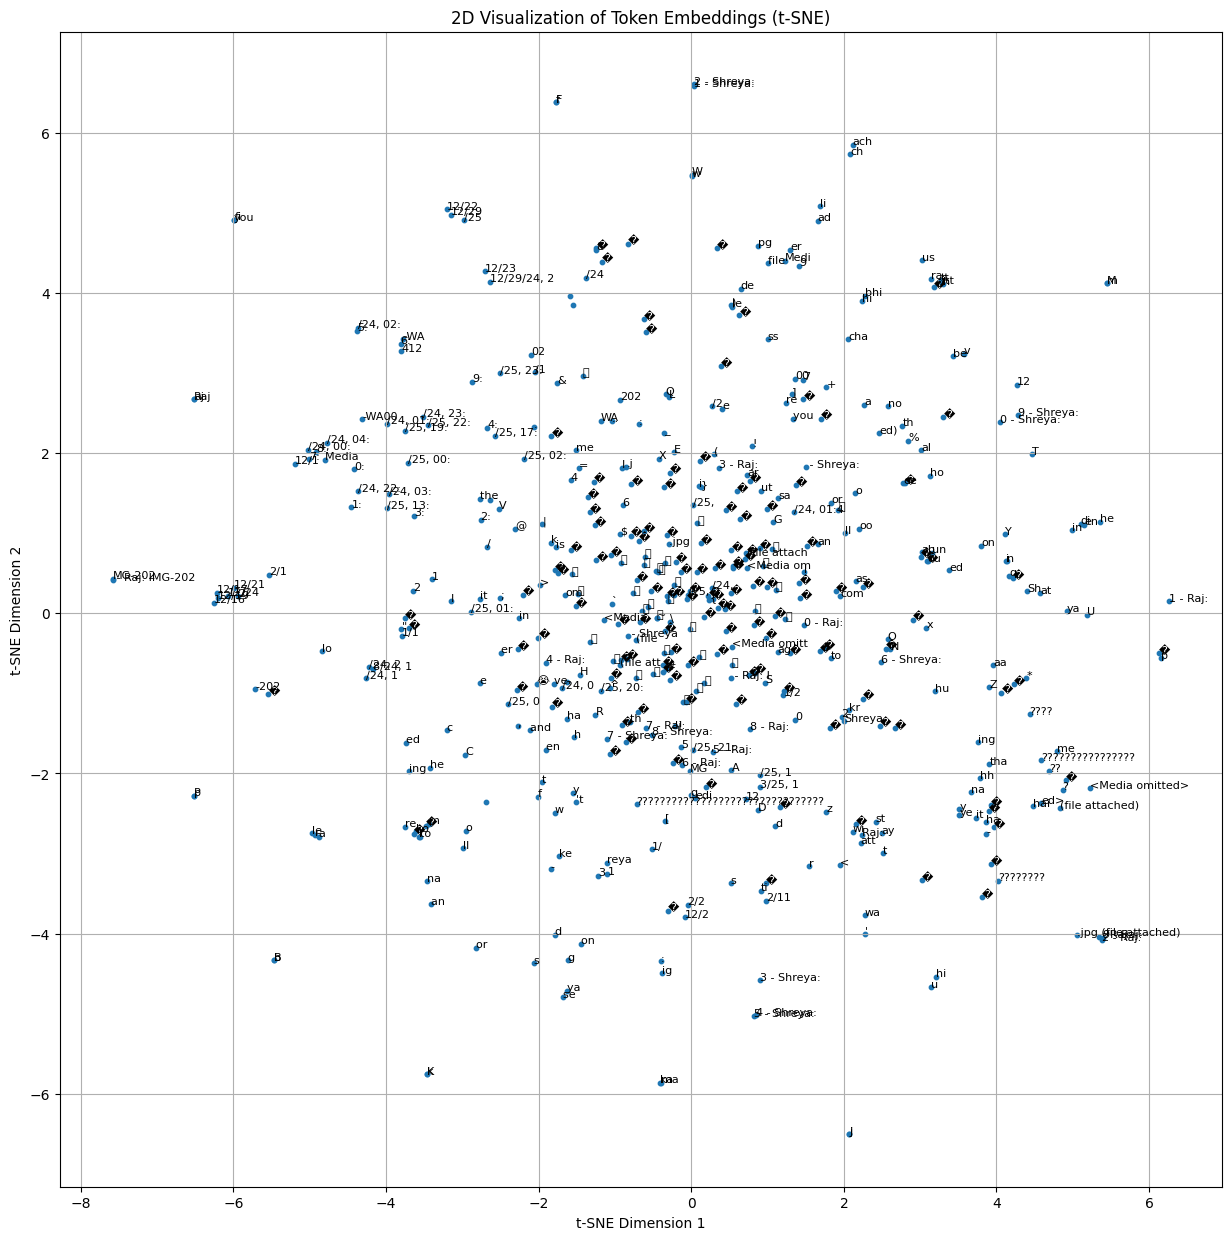

In [39]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

# Extract the embedding weights
embedding_matrix = model.token_emb.get_weights()[0]

# Perform t-SNE dimensionality reduction to 2 dimensions
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
embedding_2d = tsne.fit_transform(embedding_matrix)

# Get the vocabulary from the tokenizer
vocab = tokenizer.vocab

# Create a dictionary to map token IDs to their string representations
id_to_string = {idx: vocab[idx].decode("utf-8", errors="replace") for idx in vocab}

# Prepare data for plotting
x_coords = embedding_2d[:, 0]
y_coords = embedding_2d[:, 1]

# Set a font that supports a wider range of characters
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'sans-serif']


# Create the scatter plot
plt.figure(figsize=(15, 15))
plt.scatter(x_coords, y_coords, s=10)

# Add labels to the points (optional, can be too crowded)
for i, word in id_to_string.items():
    plt.annotate(word, (x_coords[i], y_coords[i]), fontsize=8)


plt.title("2D Visualization of Token Embeddings (t-SNE)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)

# Save the plot to a file
plot_save_path = "./token_embeddings_tsne_plot.png"
plt.savefig(plot_save_path, dpi=300)
print(f"Plot saved to {plot_save_path}")

plt.show()